In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Se va empezar con lo entendimiento dos sin movimiento
- Las columnas SOLD_AMOUNT y SOLD_QUANTITY contienen únicamente valores nulos en este subconjunto. Estos nulos no representan datos faltantes por error, sino que son nulos estructurales, lo que significa que estas ofertas no tuvieron ventas. Esto se confirma porque, en todos los casos, REMAINING_STOCK_AFTER_END es igual a INVOLVED_STOCK, indicando que no hubo movimiento de inventario.
- Este comportamiento se analizará considerando dimensiones como el tiempo de publicación, la duración de la oferta, la categoría del producto (VERTICAL), el dominio agregado (DOM_DOMAIN_AGG1), el Tipo de envío (SHIPPING_PAYMENT_TYPE) y el origen (ORIGIN). El objetivo es identificar patrones y posibles factores asociados a la falta de ventas.

In [2]:
df_no_mov = pd.read_parquet('../../data/01_processed/ofertas_relampago_sin_ventas_stock_no_movimentado.parquet')

In [3]:
df_no_mov.sample(3)

,OFFER_START_DATE,OFFER_START_DTTM,OFFER_FINISH_DTTM,OFFER_TYPE,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,SOLD_QUANTITY,ORIGIN,SHIPPING_PAYMENT_TYPE,DOM_DOMAIN_AGG1,VERTICAL,DOMAIN_ID
2605,2021-07-23,2021-07-23 19:00:00+00:00,2021-07-23 19:00:01+00:00,lightning_deal,5,5,NaN,NaN,None,none,PHARMACEUTICS,BEAUTY & HEALTH,MLM-ANTIBACTERIAL_GELS
6073,2021-07-30,2021-07-30 12:00:00+00:00,2021-07-30 20:00:00+00:00,lightning_deal,20,20,NaN,NaN,A,free_shipping,FOOTWEAR,APP & SPORTS,MLM-SNEAKERS
1731,2021-06-12,2021-06-12 12:00:00+00:00,2021-06-12 20:00:00+00:00,lightning_deal,3,3,NaN,NaN,A,free_shipping,TOYS AND GAMES,T & B,MLM-TOY_BUILDING_SETS


## Cuasi metad das ofertas fueran sin movimientos, recorda que tuviemos ~45k de lineas y con ese Se tienen 23k
- Se va investigar las principales verticales, tipos de shipping y dominio

In [4]:
df_no_mov.describe(include= 'all')

,OFFER_START_DATE,OFFER_START_DTTM,OFFER_FINISH_DTTM,OFFER_TYPE,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,SOLD_QUANTITY,ORIGIN,SHIPPING_PAYMENT_TYPE,DOM_DOMAIN_AGG1,VERTICAL,DOMAIN_ID
count,23579,23579,23579,23579,23579.000000,23579.000000,0.0,0.0,5873,23579,23579,23579,23579
unique,61,715,2844,1,NaN,NaN,NaN,NaN,1,2,36,9,1031
top,2021-07-09,2021-07-30 07:00:00+00:00,2021-07-08 19:00:01+00:00,lightning_deal,NaN,NaN,NaN,NaN,A,free_shipping,HOME&DECOR,APP & SPORTS,MLM-WRISTWATCHES
freq,698,189,47,23579,NaN,NaN,NaN,NaN,5873,14455,3317,6589,256
mean,NaN,NaN,NaN,NaN,15.675898,15.675898,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,45.018245,45.018245,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,5.000000,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,10.000000,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,15.000000,15.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<b> De las descriciones que Se tienen por supuesto no sea un problema de shipping pues más de la metad de esos son free_shipping. </b>
- Se va investigar un poquito más las categorias

<b> Home & Decor sola gaña lo top, pero APP tiene muchas categorias distribuidas y por eso Se observa que está rankeada como 1 de las verticales </b>

In [5]:
# Convertir fechas
df_no_mov["OFFER_START_DTTM"] = pd.to_datetime(df_no_mov["OFFER_START_DTTM"])
df_no_mov["OFFER_FINISH_DTTM"] = pd.to_datetime(df_no_mov["OFFER_FINISH_DTTM"])

# Duración de la oferta en horas
df_no_mov["DURATION_HOURS"] = (df_no_mov["OFFER_FINISH_DTTM"] - df_no_mov["OFFER_START_DTTM"]).dt.total_seconds() / 3600

In [6]:
df_no_mov["DURATION_HOURS"].mean()

5.448181573999462

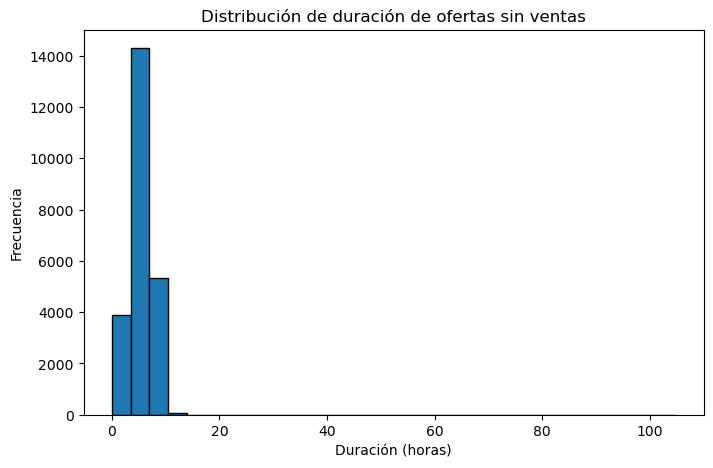

In [7]:
# Histograma de duración
plt.figure(figsize=(8,5))
plt.hist(df_no_mov["DURATION_HOURS"], bins=30, edgecolor="black")
plt.title("Distribución de duración de ofertas sin ventas")
plt.xlabel("Duración (horas)")
plt.ylabel("Frecuencia")
plt.show()

### Por lo histograma Se tienen que:
- La distribuicion esta concentrada en la izquieda eso por si ya nos demonstra que Se tienen outliers, probable es lo de APP que ya Se observa en otra etapa
- Bien concentrada entre 0 y 10 horas o que pondrian ser testes pero aun esta en la media de 6 horas

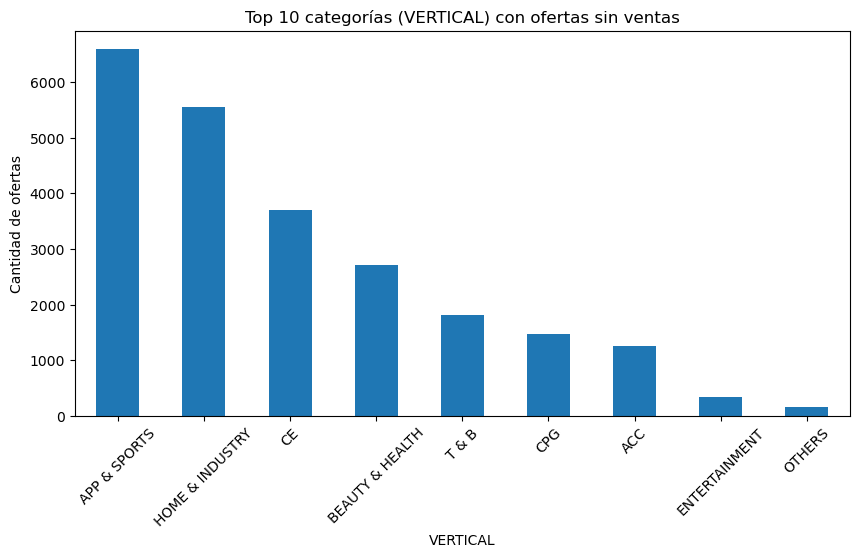

In [8]:
# Top categorías (VERTICAL)
plt.figure(figsize=(10,5))
df_no_mov["VERTICAL"].value_counts().head(10).plot(kind="bar")
plt.title("Top 10 categorías (VERTICAL) con ofertas sin ventas")
plt.ylabel("Cantidad de ofertas")
plt.xticks(rotation=45)
plt.show()


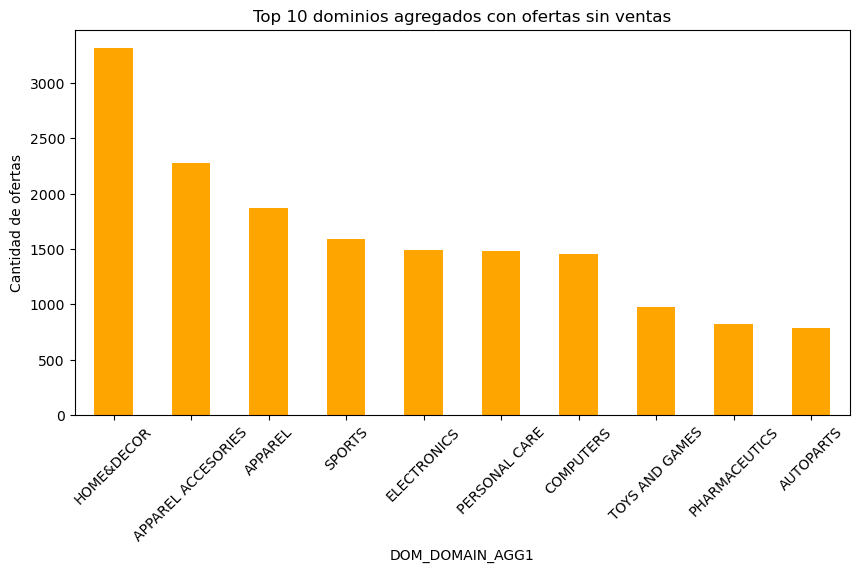

In [9]:
# Top dominios agregados (DOM_DOMAIN_AGG1)
plt.figure(figsize=(10,5))
df_no_mov["DOM_DOMAIN_AGG1"].value_counts().head(10).plot(kind="bar", color="orange")
plt.title("Top 10 dominios agregados con ofertas sin ventas")
plt.ylabel("Cantidad de ofertas")
plt.xticks(rotation=45)
plt.show()

## Por supuesto miramo que las top 5 domain son de APP y HOME & Industry
- La mayor categoria es Home & Decor
- La segunda, tercera y cuarta son de APP y sports que es donde están las mayores ofertas que no tiene ninguna venta

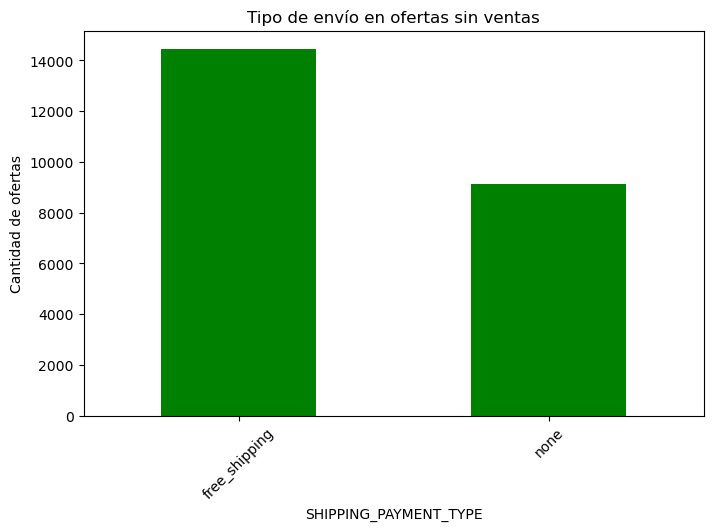

In [10]:
# Efecto del tipo de envío
plt.figure(figsize=(8,5))
df_no_mov["SHIPPING_PAYMENT_TYPE"].value_counts().plot(kind="bar", color="green")
plt.title("Tipo de envío en ofertas sin ventas")
plt.ylabel("Cantidad de ofertas")
plt.xticks(rotation=45)
plt.show()

## Se tienen más de la metad en free_shipping entonces no Se podrá considerar ese uno de los factores tambien.

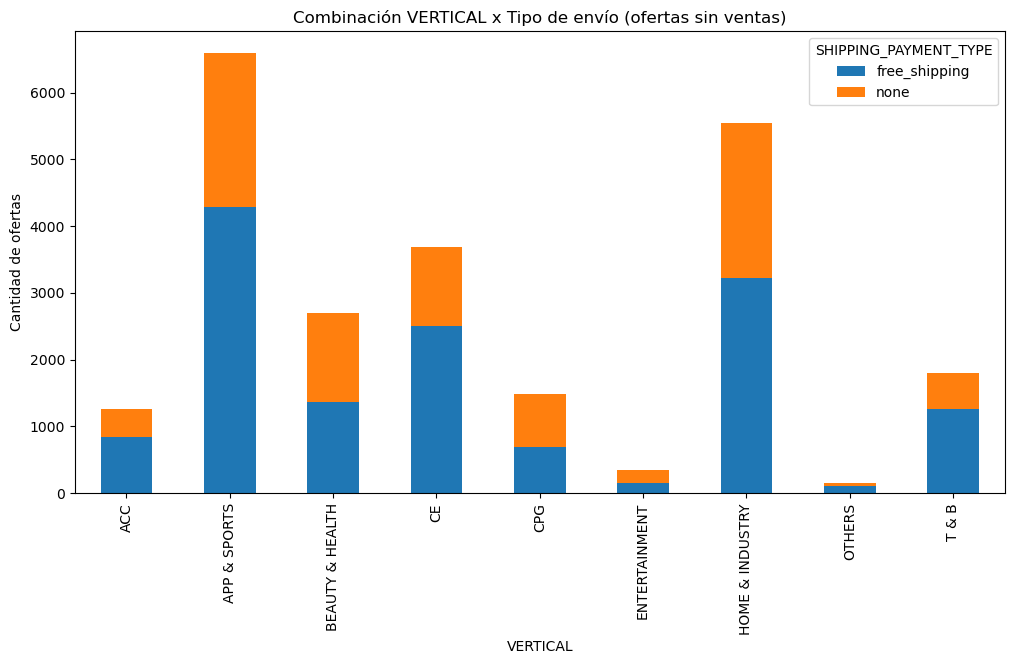

In [11]:
# Cross-tab VERTICAL x Tipo de envío
tabla_cross = pd.crosstab(df_no_mov["VERTICAL"], df_no_mov["SHIPPING_PAYMENT_TYPE"])
tabla_cross.plot(kind="bar", stacked=True, figsize=(12,6))
plt.title("Combinación VERTICAL x Tipo de envío (ofertas sin ventas)")
plt.ylabel("Cantidad de ofertas")
plt.xticks(rotation=90)
plt.show()